<a href="https://colab.research.google.com/github/pachecoleonardo/aprendizaje_no_supervisado/blob/master/04_densidad_dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> Aplicación de los Métodos de Agrupamiento</h1></center>
<center><h1> Aprendizaje No Supervisado</h1></center>
<center><h1> Agrupamiento basado en densidad : DBSCAN</h1></center>
<br>

### - Alexandro López González
### - Leonardo Pacheco Garduño
### - Manuel Garcia Sanes
<br>
<br>

En este notebook, realizaremos los siguiente:

- Aplicación del algoritmo DBSCAN  a los dos datasets seleccionados. 

- Evaluación de los resultados utilizando métricas intrínsecas o extrínsecas según sea el caso

- Análisis del resultado
<br>
<br>


## 1. Cargamos las librerias necesarias

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## 2. Cargamos el dataset con agrupamiento conocido

**Nombre:<br>

SEEDS<br>

**Abstract: 

Measurements of geometrical properties of kernels belonging to three different varieties of wheat. A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes.<br>

**Atributos (Reales): <br>

area A,<br>
perimeter P,<br>
compactness C = 4piA/P^2,<br>
length of kernel,<br>
width of kernel,<br>
asymmetry coefficient<br>
length of kernel groove. All of these parameters were real-valued continuous.<br>

**Instancias:**<br>

210<br>

URL:<br>
https://archive.ics.uci.edu/ml/datasets/seeds#

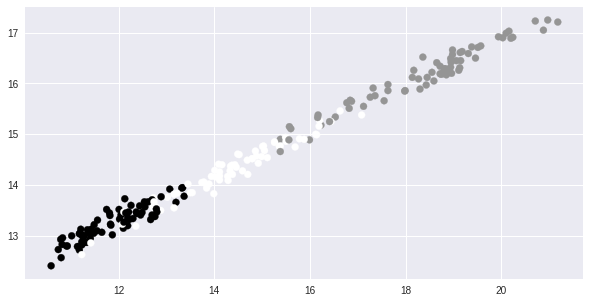

In [3]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'

D = np.array(pd.read_csv(data_file_url,delimiter='\s+', header=None))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:-1]
Dy = D[:,-1]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = Dy)


Uno de los pasos clave del algoritmo DBSCAN es el descubrimiento del vecindario (de un ejemplo $x_i$). Para ello sólo se precisa de la matriz de distancias y el parámetro $\epsilon$ que marca un umbral en la distancia máxima entre dos puntos que define el vecindario:


In [0]:
def encuentra_vecindario(mDistancia, i, eps):
    vecinos = np.where(mDistancia[i,:] < eps)[0]
    
    vecinos = vecinos[vecinos != i]
            
    return vecinos


Aparte de ello, el algoritmo DBSCAN recorre el conjunto de datos y para cada ejemplo, si no ha sido asignado a otro clúster y tiene un número de vecinos mínimo necesario $M$, crea un nuevo clúster y asigna al mismo todos los ejemplos no asignados denso-alcanzables:


In [0]:
def agrupamiento_densidad_DBSCAN(mDistancia, eps, M):
 
    labels = np.zeros(mDistancia.shape[0])
    C = 0
    
    for i in np.arange(mDistancia.shape[0]):
    
        if labels[i] != 0:
            continue
        
        vecindario = encuentra_vecindario(mDistancia, i, eps)
        
        if len(vecindario)<M:
            # Si NO es un punto nuclear
            labels[i] = -1
        else:  
            # Si es un punto nuclear
            C += 1
            labels[i] = C
            expandir_cluster(mDistancia, labels, vecindario, C, eps, M)
    
    return labels


La función 'expandir_cluster' trata de asignar otros ejemplos más allá del vecindario de $x_i$ al nuevo clúster que se ha creado para él. Busca entre los ejemplos del vecindario actual y si alguno de ellos es un punto nuclear (mínimo número de vecinos, $M$), se incorpora su vecindario al vecindario del clúster que se está explorando. Todos los elementos del vecindario se asignan al clúster:


In [0]:
def expandir_cluster(mDistancia, labels, vecindario, C, eps, M):
    it = 0
    while it < vecindario.size:
        j = vecindario[it]
       
        if labels[j] == -1:
            labels[j] = C
        elif labels[j] == 0:
            labels[j] = C
            
            vecindario_j = encuentra_vecindario(mDistancia, j, eps)
            
            if vecindario_j.size >= M:
                vecindario = np.append(vecindario, vecindario_j)
        it += 1        


Con estas tres funciones ya podemos ejecutar el algoritmo DBSCAN. Sólo necesitamos la matriz de distancias y asignar valor al umbral que define el vecindario ($\epsilon$) y al umbral que define un punto nuclear ($M$):


In [0]:
from sklearn.metrics.pairwise import euclidean_distances

eps = .07
M = 38

mDistancia = euclidean_distances(Dx)
Dyp = agrupamiento_densidad_DBSCAN(mDistancia,eps,M)


Dibujamos los resultados de la siguiente manera:


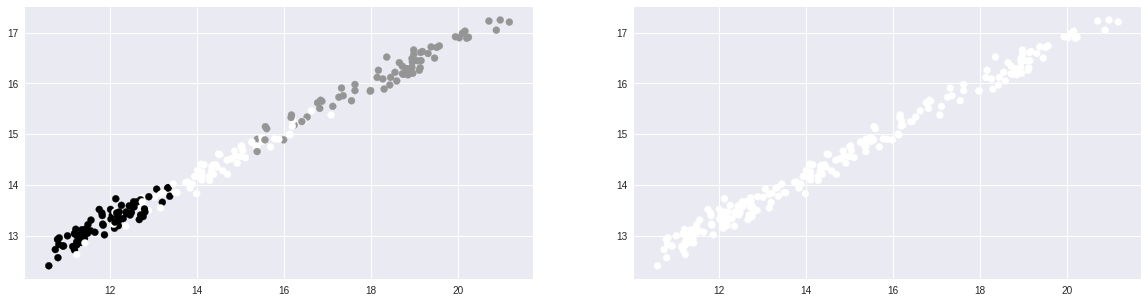

In [9]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[1].scatter(Dx[:,0], Dx[:,1], c = Dyp)


Y las métricas de bondad del agrupamiento son:


In [12]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k] * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

mC = matriz_confusion(Dy,Dyp)

print(mC)
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('El valor F1 es = ', medida_f1(mC))

[[70]
 [70]
 [70]]
El valor del error cometido es =  0.0
La pureza del agrupamiento obtenido es =  0.3333333333333333
El valor F1 es =  0.5



Nótese que la primera columna no corresponde realmente a un clúster predicho, sino a todo los ejemplos que DBSCAN considera ruido y no asigna a ningún clúster.


<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering DBSCAN.

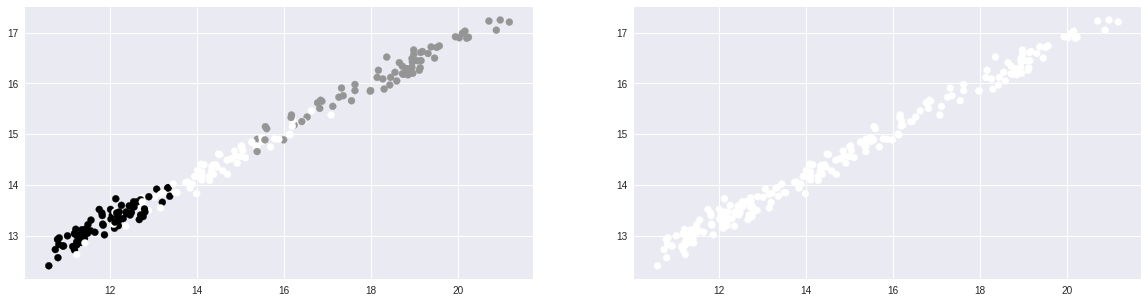

In [13]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=eps, min_samples=M).fit(Dx)

# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[1].scatter(Dx[:,0], Dx[:,1], c = clustering.labels_)

<hr>
Podemos jugar con diferentes valores de $\epsilon$ y $M$ para ver su efecto sobre diferentes conjuntos de datos:


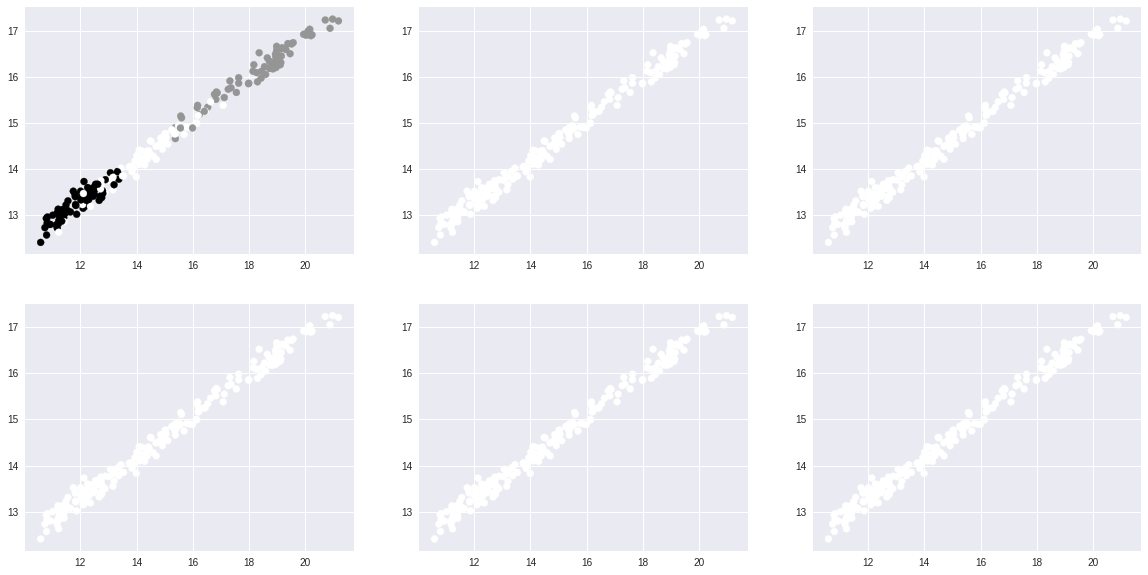

In [15]:
data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'

D = np.array(pd.read_csv(data_file_url,delimiter='\s+', header=None))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:-1]
Dy = D[:,-1]

mDistancia = euclidean_distances(Dx)

Dyp1 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.03,M=38)
Dyp2 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.07,M=38)
Dyp3 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.05,M=25)
Dyp4 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.03,M=18)
Dyp5 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.07,M=18)

fig, ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[0,1].scatter(Dx[:,0], Dx[:,1], c = Dyp1)
ax[0,2].scatter(Dx[:,0], Dx[:,1], c = Dyp2)
ax[1,0].scatter(Dx[:,0], Dx[:,1], c = Dyp3)
ax[1,1].scatter(Dx[:,0], Dx[:,1], c = Dyp4)
ax[1,2].scatter(Dx[:,0], Dx[:,1], c = Dyp5)

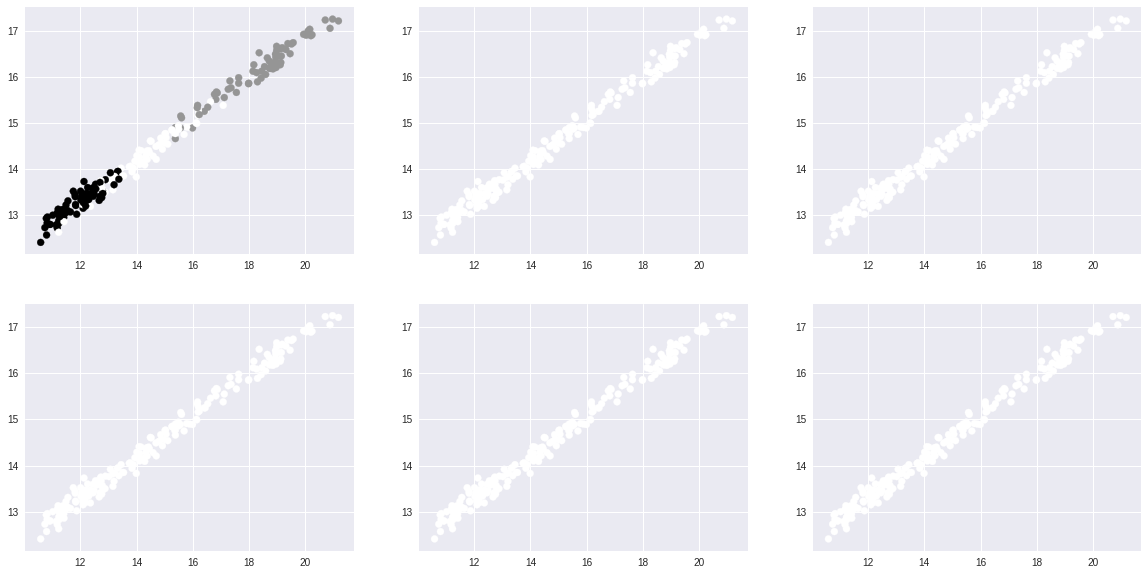

In [16]:
data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'

D = np.array(pd.read_csv(data_file_url,delimiter='\s+', header=None))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:-1]
Dy = D[:,-1]


mDistancia = euclidean_distances(Dx)

Dyp1 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.03,M=38)
Dyp2 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.07,M=38)
Dyp3 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.05,M=25)
Dyp4 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.03,M=18)
Dyp5 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.07,M=18)

fig, ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[0,1].scatter(Dx[:,0], Dx[:,1], c = Dyp1)
ax[0,2].scatter(Dx[:,0], Dx[:,1], c = Dyp2)
ax[1,0].scatter(Dx[:,0], Dx[:,1], c = Dyp3)
ax[1,1].scatter(Dx[:,0], Dx[:,1], c = Dyp4)
ax[1,2].scatter(Dx[:,0], Dx[:,1], c = Dyp5)

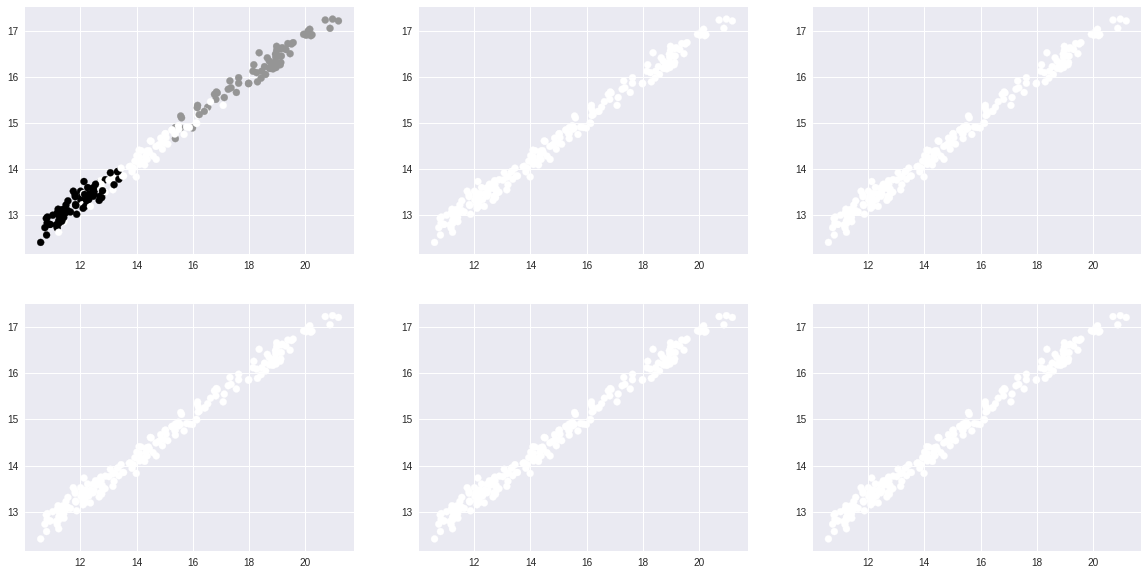

In [17]:
data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'

D = np.array(pd.read_csv(data_file_url,delimiter='\s+', header=None))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:-1]
Dy = D[:,-1]


mDistancia = euclidean_distances(Dx)

Dyp1 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.03,M=38)
Dyp2 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.07,M=38)
Dyp3 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.05,M=25)
Dyp4 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.03,M=18)
Dyp5 = agrupamiento_densidad_DBSCAN(mDistancia,eps=.07,M=18)

fig, ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[0,1].scatter(Dx[:,0], Dx[:,1], c = Dyp1)
ax[0,2].scatter(Dx[:,0], Dx[:,1], c = Dyp2)
ax[1,0].scatter(Dx[:,0], Dx[:,1], c = Dyp3)
ax[1,1].scatter(Dx[:,0], Dx[:,1], c = Dyp4)
ax[1,2].scatter(Dx[:,0], Dx[:,1], c = Dyp5)